In [1]:
%matplotlib inline
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#data_folder = os.path.join("Users", "bitarafa","Documents","Projects⁩","⁨Nanoclusters⁩", "⁨Measurements⁩","231118")
#path = os.path.join(data_folder, "10","4MW","A")
#file_to_open = os.path.join(path, "121218_X980.tif")
#print path
#path = "C:\\Users\\Applied Optician\\Documents\\Mohammad\\231118\\10\\2MW\\A"
#cwd = os.getcwd()
#print cwd

In [3]:
'''Exposure time used for the expriment'''
'''12 to 18 Dec 2018'''
ExposureTime = 0.01
dt = ExposureTime + 0.01735 # real time step

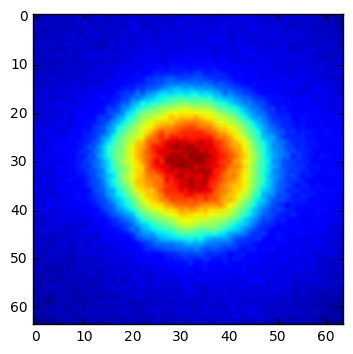

In [149]:
'''Set the path to data and count '''
path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/121218/5/2MW/B/"
# open one file to make sure it is working
img = cv2.imread(path+'121218_X100.tif',-1)
plt.imshow(img)
plt.show()

(31, 30)


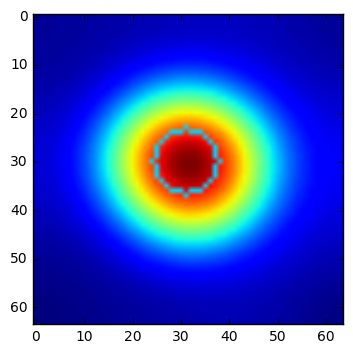

In [150]:
'''find the brightest spot of the image'''
# This needs to be done only one time and then use the point for all image processing
gray = cv2.GaussianBlur(img, (31, 31), -1)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(gray)
ave_r1 = 7# radious of the circle
print maxLoc
#maxLoc=(29, 31)
max_x , max_y = maxLoc
img2 = cv2.circle(gray, maxLoc, ave_r1,(255,255,255) , 1)
#img2 = cv2.circle(gray, maxLoc, ave_r1+2,(255,255,255) , 1)
plt.imshow(img2)
plt.show()

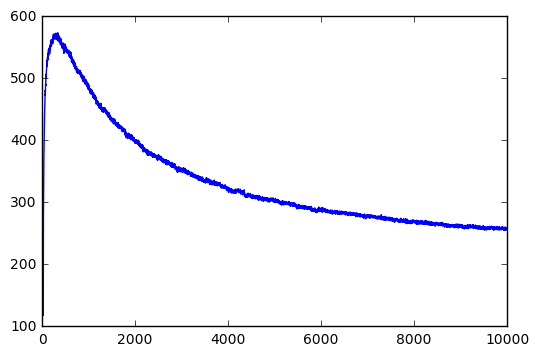

In [151]:
'''Inner circle'''
path, dirs, files = next(os.walk(path))
file_count = len(files)
images1 = []
images_dif = np.array([])
ave_r1 = 3

prefix = files[0]
prefix = prefix[:prefix.find('X') + 1]
for i in range(file_count-1):
    f_name = prefix + str(i+1) + '.tif'
    img = cv2.imread(path+f_name,-1)# - background
    #(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img)
    images1.append((np.mean(img[max_y-ave_r1+1:max_y+ave_r1,max_x-ave_r1+1:max_x+ave_r1])))
    
images1 = np.array(images1)

plt.plot(images1)
plt.show()

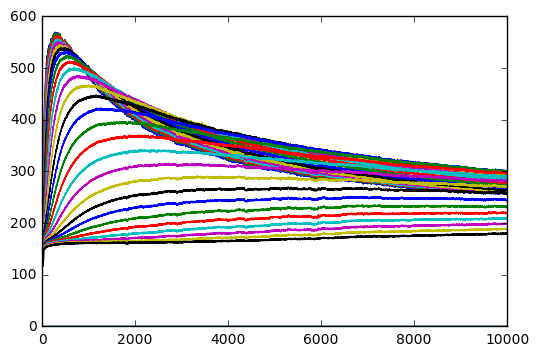

In [152]:
'''Multiple areas'''
#path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/Slide_noOil/4MW/A/"
path, dirs, files = next(os.walk(path))
file_count = len(files)
prefix = files[0]
prefix = prefix[:prefix.find('X') + 1]
step = 1 # thickness of the area in pixel
q = file_count-1

# Find number of areas p
if ( max_x > max_y ):
    p = 64 - max_x - 3 
else:
    p = 64 - max_y - 3
    
images_dif  = np.empty([q, p])
for i in range(0,q):  #
    f_name = prefix + str(i+1) + '.tif'
    img = cv2.imread(path+f_name,-1)# - background
    ave_r1 = 3
    ave_r2 = ave_r1 + step
    #(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img)
    for j in range(0,p):
        if (max_y-ave_r1+1 < 0) or (max_y+ave_r1 > 64) or (max_x-ave_r1+1 < 0) or (max_x+ave_r1 > 64):
            break
        if (max_y-ave_r2+1 < 0) or (max_y+ave_r2 > 64) or (max_x-ave_r2+1 < 0) or (max_x+ave_r2 > 64):
            break
        sum1 = np.sum(img[max_y-ave_r1+1:max_y+ave_r1,max_x-ave_r1+1:max_x+ave_r1])#/n1
        sum2 = np.sum(img[max_y-ave_r2+1:max_y+ave_r2,max_x-ave_r2+1:max_x+ave_r2])#/n2
        n1 = (2*ave_r1-1)**2
        n2 = (2*ave_r2-1)**2
        #sum_dif = np.append(sum_dif,[(sum2 - sum1)/(n2-n1)])
        #sum_dif = np.vstack(sum_dif,(sum2 - sum1)/(n2-n1))
        images_dif[i,j] = (sum2 - sum1)/(n2-n1)
        ave_r1 = ave_r1 + step
        ave_r2 = ave_r1 + step
plt.plot(images_dif)
plt.show()

In [153]:
# attaching the central circle to the rest of data
data = np.empty([q, p+1])
data[:,1:] = images_dif
data[:,0] = images1

In [154]:
'''removing data before having the laser on'''
n_data = 9500
n_col = 27 # number of column in 2MW background
step_arg = np.argmax(np.diff(data[:,0])) # find the step
#for i in range (data.shape[1]):
data_new = data[step_arg+1:n_data+step_arg+1,:n_col]

In [11]:
'''load the background'''
save_path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/181218/Processed/2MW/"
filename = '231118_181218_PVA_2MW_Ave'
background = np.load(save_path + filename+'.npy')

In [155]:
data_normalized = data_new - background

In [18]:
def intensity(n):
    I0 = 2e6
    BeamDiameter = 55e-6 # estimated from the image on camera and by fitting to a gaussian profile
    w0 = BeamDiameter/2
    Camera_pixel = 16e-6
    pixel_sample = 16e-6/100
    pixel_8_bin = 8*pixel_sample
    I = I0*np.exp(-2*(n*pixel_8_bin)**2/w0**2)/1e6
    return I
n = np.arange(0,32)
I_legend = np.round(intensity(n),2)
#print I_legend

I_new = np.delete(I_legend,[1,2,3])
#print I_new
print I_new.shape

(29,)


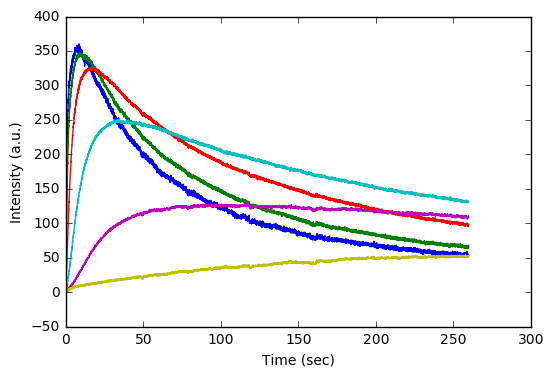

In [157]:
##### '''Plot vs. time'''
t = np.arange(n_data)*dt

'''Save data'''
save_path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/121218/5/2MW/Processed/"
filename = '231118_121218_5_2MW_B_Processed'
np.save(save_path + filename, data_normalized)

fig, ax = plt.subplots(1)#figsize=(10,6)
for i in range (0,28,5):
    ax.plot(t,data_normalized[:,i], label = str(I_new[i]))
#ax.set_xlim([0, 50])
plt.xlabel('Time (sec)')
plt.ylabel('Intensity (a.u.)')
#ax.xaxis.set_tick_params(labelsize=14)
#ax.yaxis.set_tick_params(labelsize=14)
#ax.legend()
plt.savefig(save_path+filename+'_6Lines'+'.png', bbox_inches='tight')
plt.show()

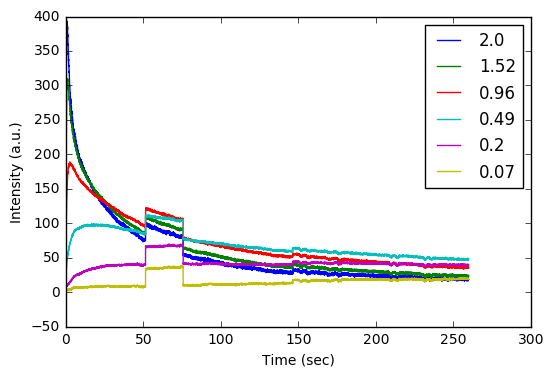

In [114]:
## '''Averaging data'''


A = np.load(save_path+'231118_121218_10_2MW_A_Processed'+'.npy')
B = np.load(save_path+'231118_121218_10_2MW_B_Processed'+'.npy')
C = np.load(save_path+'231118_121218_10_2MW_A_Processed'+'.npy')
D = np.load(save_path+'231118_121218_10_2MW_A_Processed'+'.npy')
E = np.load(save_path+'231118_121218_10_2MW_A_Processed'+'.npy')




I = (A+B+C+D+E)/5

filename = '231118_121218_10_2MW_Ave'
fig, ax = plt.subplots(1)#figsize=(10,6)
for i in range (0,28,5):
    ax.plot(t,I[:,i], label = str(I_new[i]))
#ax.set_xlim([0, 50])
plt.xlabel('Time (sec)')
plt.ylabel('Intensity (a.u.)')
#ax.xaxis.set_tick_params(labelsize=14)
#ax.yaxis.set_tick_params(labelsize=14)
ax.legend()
#plt.savefig(save_path+filename+'_6Lines_Full_Legend'+'.png', bbox_inches='tight')
plt.show()

#filename = '231118_121218_10_2MW_Ave'
np.save(save_path + filename, I)

In [212]:
file_name = '231118_121218_5_2MW_B_Processed'
data_normalized = np.load('5/2MW/Processed/'+file_name+'.npy')

[  3.41591528e+02   1.63419353e-02  -3.12482891e+02   6.05803984e-01
   5.36435639e+01]


TypeError: func3() takes exactly 8 arguments (6 given)

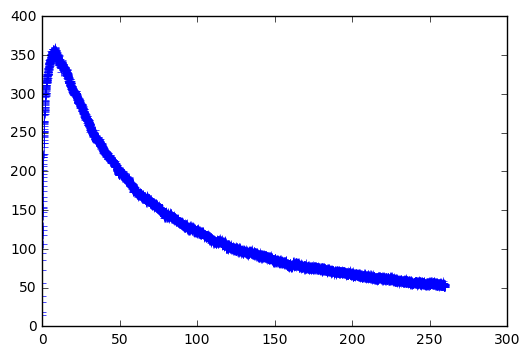

In [217]:
from scipy.signal import argrelextrema
I = data_normalized[:,0]#I[:,0]
#print np.argmax(I)
I2fit = I#[np.argmax(I):]
#fig, ax = plt.subplots()#figsize=(10,6)
#ax.plot(t[np.argmax(I):],I2fit)

from scipy.optimize import curve_fit

#def func1(x, a, b, c):
#    return a * np.exp(-b * x) + c
  #return a * np.log(b * x) + c

def func2(x,a1,b1,a2,b2,c):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c

def func3(x,a1,b1,a2,b2,a3,b3,c):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + a3 * np.exp(-b3 * x) + c 

x = t#[np.argmax(I):]   # changed boundary conditions to avoid division by 0
#y = func(x, 500, 0.05, 20)
#p1 = np.array([300, 0.04, 200], dtype=np.double)
p2 = np.array([  3.41591580e+02,   1.63419400e-02,   
        -3.12482578e+02,   6.05802271e-01,5.36435767e+01])

#p3 = np.array([   -10e+02,   1/1.0,2.52969490e+02,   1/50.0 ,
 #  2.33605573e+02,   1/100.0  , 1], dtype=np.double)
    
#p3 = np.array([ -1e+02,   1/4.0,   1.46311353e+02,
         #2.93490039e-02,   2.18711224e+02,   8.02835298e-03,
         #3.45672443e+01])
        
#p3 =  np.array([  1.46312383e+02 ,  2.93488540e-02,  -2.63346816e+02 ,  2.98270911e+00,
#   2.18710346e+02,   8.02830805e-03 ,  3.45670175e+01])


def fit(p, x, y):
    return curve_fit(func2, x, y, p0 = p)

#p3 = popt
popt, pcov = fit(p2, x, I2fit)
#popt = p3
print popt
fig, ax = plt.subplots()
ax.plot(x, I2fit, '+', label="Experiment")
ax.plot(x, func(x, *popt), 'r-', label="Fit")

tau2 = np.round(1/popt[1],2)
tau1 = np.round(1/popt[3],1)
tau3 = np.round(1/popt[5])
leg_pos_y = 250
ax.text(100, leg_pos_y, r'$\tau_1 = $'+str(tau1)+' s')
ax.text(100, leg_pos_y-50, r'$\tau_2 = $'+str(tau2)+' s')
ax.text(100, leg_pos_y-100, r'$\tau_3 = $'+str(tau3)+' s')
ax.set_xlim([-1,200])
plt.xlabel('Time (sec)')
plt.ylabel('Intensity (a.u.)')
#np.save('5/2MW/Processed/'+file_name+'FitParam_2exp', popt)
#plt.savefig(save_path+filename+'_2MW_Full_fit'+'.png', bbox_inches='tight')
#plt.legend()
plt.show()

In [200]:
np.load('5/2MW/Processed/'+file_name+'FitParam_2exp.npy')

array([  3.41591580e+02,   1.63419400e-02,   5.36435767e+01,
        -3.12482578e+02,   6.05802271e-01])

In [135]:
tau1 = np.round(1/popt[1],2)
print str(tau1)

0.34


In [188]:
a1,b1,a2,b2,a3,b3,c = popt

tau1 = 1/b1
tau2 = 1/b2
tau3 = 1/b3

print 'tau1 = %0.2f' %tau1
print 'tau2 = %0.2f' %tau2
print 'tau3 = %0.2f' %tau3

ValueError: need more than 5 values to unpack

(0, 30)

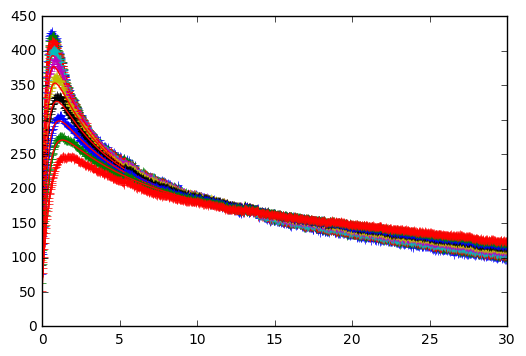

In [334]:
def func3(x,a1,b1,a2,b2,a3,b3,c):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + a3 * np.exp(-b3 * x) + c 

def fit(p, x, y):
    return curve_fit(func3, x, y, p0 = p)
x = t#[np.argmax(I):]   # changed boundary conditions to avoid division by 0

tau1=[]
tau2=[]
tau3=[]

#popt = np.array([   -3.97504872e+02,   5.23058017e+00,2.52969490e+02,   4.50849678e-01 ,2.33605573e+02,   3.27748245e-02  , 1.38720893e+01])

fig, ax = plt.subplots()
for i in range(0,10):
    I = data_normalized[:,i]
    I2fit = I#[np.argmax(I):]
    p3 = np.array([   -3.97504872e+02,   5.23058017e+00,2.52969490e+02,   4.50849678e-01 ,2.33605573e+02,   3.27748245e-02  , 1.38720893e+01], dtype=np.double)
    #p3 = popt   
    popt, pcov = fit(p3, x, I2fit)
    tau1.append(1/popt[1])
    tau2.append(1/popt[3])
    tau3.append(1/popt[5])
    ax.plot(x, I2fit, '+', label="Experiment")
    ax.plot(x, func3(x, *popt), 'r-', label="Fit")
ax.set_xlim([0,30])    

15
16
17


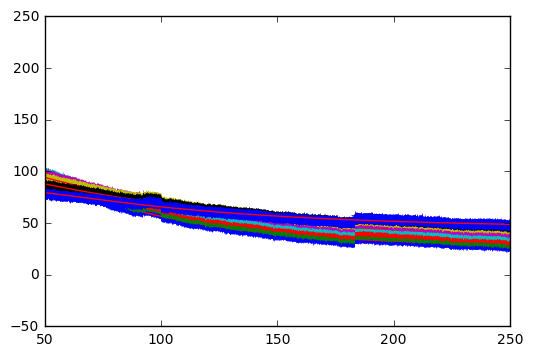

In [338]:
fig, ax = plt.subplots()
for i in range(10,15):
    I = data_normalized[:,i]
    I2fit = I#[np.argmax(I):]
    p3 = np.array([ -2.18024251e+02,   2.26836295e+00,   7.66814474e+01,
         1.74122217e-01,   1.71709409e+02,   1.86179566e-02,
         2.47430752e+01], dtype=np.double)
    popt, pcov = fit(p3, x, I2fit)
    tau1.append(1/popt[1])
    tau2.append(1/popt[3])
    tau3.append(1/popt[5])
    ax.plot(x, I2fit, '+', label="Experiment")
    ax.plot(x, func3(x, *popt), 'r-', label="Fit")
ax.set_xlim([50,250])    
p3 = popt
for i in range(15,18):
    print i
    I = data_normalized[:,i]
    I2fit = I#[np.argmax(I):]
    #p3 = popt
    #p3 = np.array([ -2.18024251e+02,   2.26836295e+00,   7.66814474e+01,
       #  1.74122217e-01,   1.71709409e+02,   1.86179566e-02,
       #  2.47430752e+01], dtype=np.double)
    popt, pcov = fit(popt, x, I2fit)
    tau1.append(1/popt[1])
    tau2.append(1/popt[3])
    tau3.append(1/popt[5])
    ax.plot(x, I2fit, '+', label="Experiment")
    ax.plot(x, func3(x, *popt), 'r-', label="Fit")   

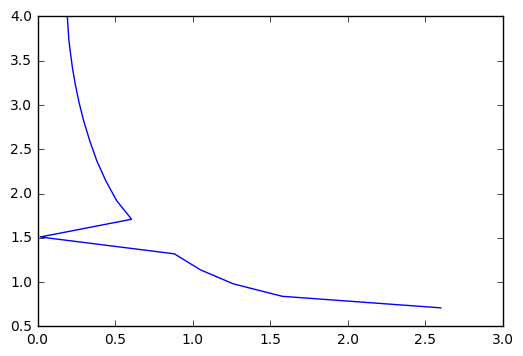

In [336]:
plt.plot(tau1,I_new[0:len(tau1)])

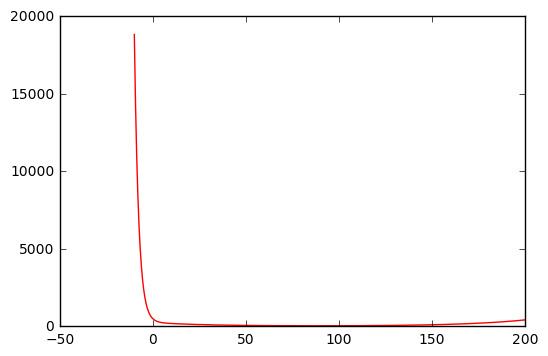

In [174]:
x = np.linspace(-10,200,1000)
popt=[  2.32735812e+02 ,  3.26632955e-02 ,  1.38434089e+01 ,  2.43540166e+02, 4.33011315e-01]
plt.plot(x, func2(x, *popt)+func1(x, 1, -0.03, 3), 'r-', label="Fitted Curve")

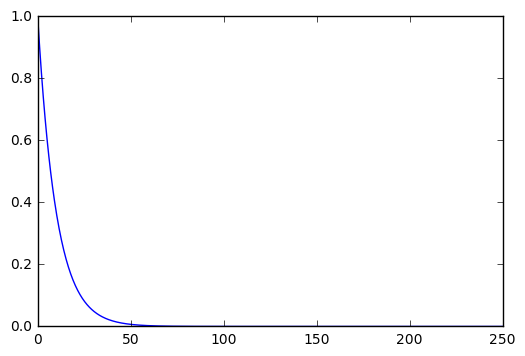

In [82]:
x = np.linspace(0,250,1000)
y = np.exp(-0.1*x)
plt.plot(x,y)

In [230]:
r =np.arange(3,15)*1e-6
f = I0*np.exp(-2*r**2/w0**2)/1e6
print f

[ 3.90591749  3.83427478  3.74409023  3.63674027  3.51383342  3.37717028
  3.2286997   3.07047278  2.90459615  2.73318587  2.55832363  2.38201616]


(30, 200)

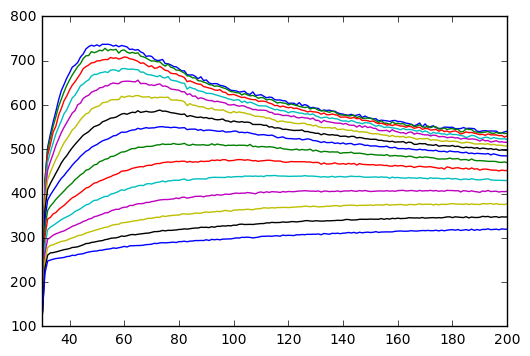

In [234]:
plt.plot(images_dif)
plt.xlim([30,200])

[ 4.    3.98  3.93  3.85  3.73  3.59  3.42  3.23  3.03  2.82  2.59  2.37
  2.14  1.92  1.71  1.51  1.32  1.14  0.98  0.84  0.71  0.59  0.49  0.4
  0.33  0.27  0.21  0.17  0.13  0.1   0.08  0.06]


1.28e-06
11.52


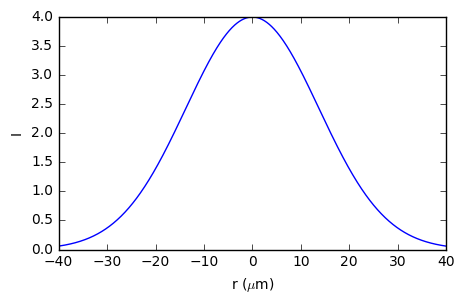

In [230]:
BeamDiameter = 55e-6 # estimated from the image on camera and by fitting to a gaussian profile
w0 = BeamDiameter/2
Camera_pixel = 16e-6
pixel_sample = 16e-6/100
pixel_8_bin = 8*pixel_sample
print pixel_8_bin
print pixel_8_bin*1e6*9
r = np.linspace(-40,40,1000)*1e-6
I0 = 4e6
f = I0*np.exp(-2*r**2/w0**2)/1e6
r_um = r*1e6
#f_MW = f/I0*100
fig, ax = plt.subplots(1,figsize = (5,3))
plt.plot(r_um,f)
ax.set(xlabel=r'r ($\mu$m)', ylabel='I')
plt.show()

237.3145211


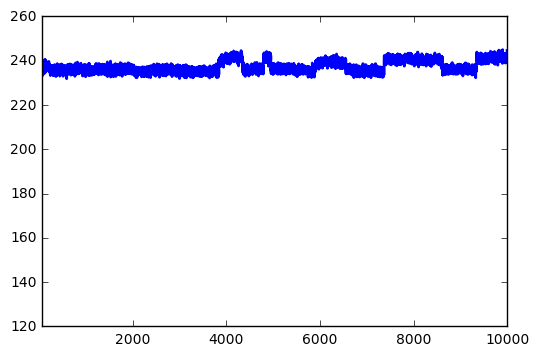

In [156]:
plt.plot(I,'-',linewidth = '2')
plt.xlim(70,10000)
print np.average(I[70:10000])

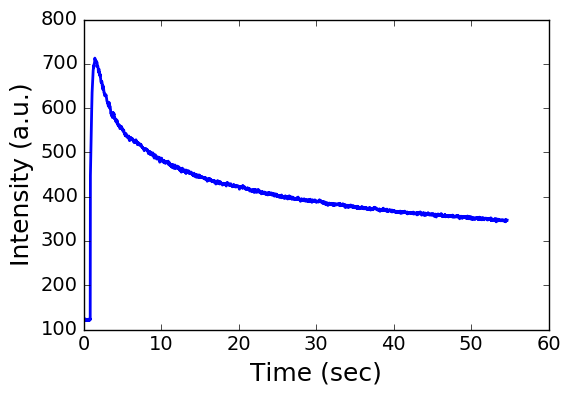

In [152]:
'''Load data'''
filename = '231118_10_4MW_A_R3'
data = np.load(save_path+filename+'.npy')
t = data[:,0]
I = data[:,1]
fig, ax = plt.subplots(1)#figsize=(10,6)
plt.plot(t,I,'-',linewidth = '2')
#plt.xlim(0,5)
plt.xlabel('Time (sec)', fontsize=18)
plt.ylabel('Intensity (a.u.)', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#plt.savefig(save_path+filename+'.png', bbox_inches='tight')
plt.show()

In [168]:
'''Average from background'''
path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/141218/CoverSlip/4MW/A/"

path, dirs, files = next(os.walk(path))
file_count = len(files)
#images = []
ave_r = 3
max_x = 31
max_y = 31
images = cv2.imread(path+'141218_X70.tif',-1)
prefix = files[0]
prefix = prefix[:prefix.find('X') + 1]
n_img = 100
for i in range(71,n_img):
    f_name = prefix + str(i+1) + '.tif'
    img = cv2.imread(path+f_name,-1)# - background
    images = images + img
    #images.append((np.mean(img[max_y-ave_r+1:max_y+ave_r,max_x-ave_r+1:max_x+ave_r])))
#images = np.array(images)
#plt.plot(images)
#plt.xlim(0,100)
n = n_img-70

In [170]:
print n

30


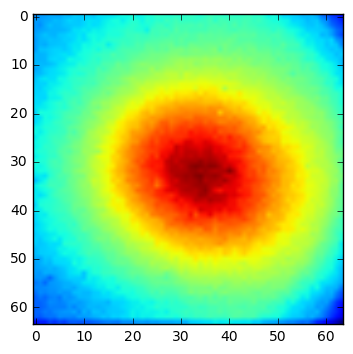

In [169]:
background = images
plt.imshow(background)

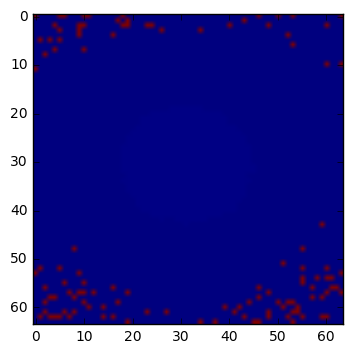

In [68]:
path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/10/4MW/D/"
images = cv2.imread(path+'121218_X100.tif',-1)
plt.imshow(images-background)

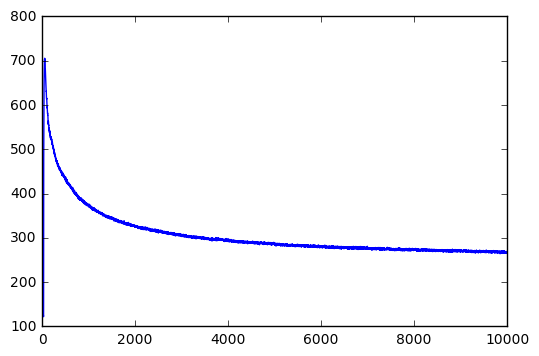

In [73]:
path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/10/4MW/D/"
path, dirs, files = next(os.walk(path))
file_count = len(files)
images = []
ave_r = 3
max_x = 31
max_y = 31

prefix = files[0]
prefix = prefix[:prefix.find('X') + 1]
for i in range(file_count-1):
    f_name = prefix + str(i+1) + '.tif'
    img = cv2.imread(path+f_name,-1) #- background
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img)
    images.append((np.mean(img[max_y-ave_r+1:max_y+ave_r,max_x-ave_r+1:max_x+ave_r])))
    #images.append((np.mean(img)))
images = np.array(images)
plt.plot(images)
#plt.xlim(0,100)
plt.show()

In [74]:
img2 = images
img1 = images

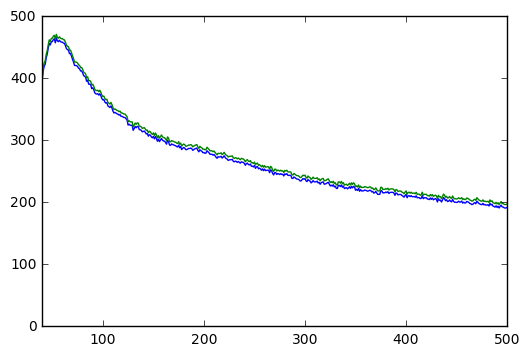

In [81]:
plt.plot(img2-240)
plt.plot(img1)
plt.xlim(40,500)
plt.ylim(0,500)
plt.show()

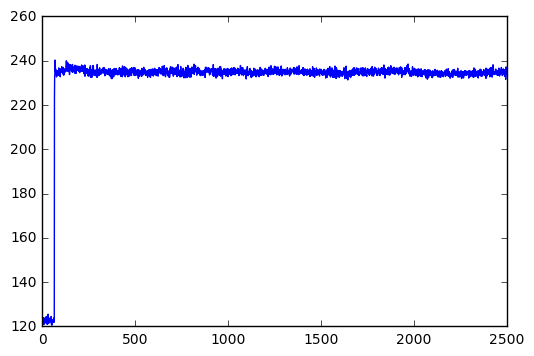

In [85]:
path = "/Users/bitarafa/Documents/Projects/Nanoclusters/Measurements/231118/CoverSlip/141218/4MW/C/"
path, dirs, files = next(os.walk(path))
file_count = len(files)
images = []
ave_r = 3
max_x = 31
max_y = 31

prefix = files[0]
prefix = prefix[:prefix.find('X') + 1]
for i in range(0,3000):
    f_name = prefix + str(i+1) + '.tif'
    img = cv2.imread(path+f_name,-1)# - background
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(img)
    images.append((np.mean(img[max_y-ave_r+1:max_y+ave_r,max_x-ave_r+1:max_x+ave_r])))
    #images.append((np.mean(img)))
images = np.array(images)
plt.plot(images)
plt.xlim(0,2500)
plt.show()

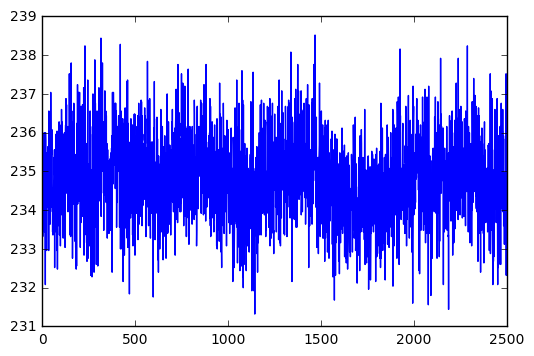

In [84]:
plt.plot(images)
#plt.xlim(0,2500)
plt.show()

In [26]:
np.average(images)

234.83152000000001

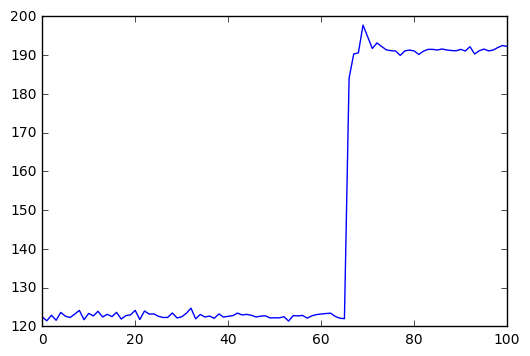

In [341]:
plt.plot(images)
plt.xlim(0,100)
plt.show()